## Retrieve player and game information from NBA Api to create datasets for shots attempted

In [131]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
import json

from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import playergamelog
    

## Gets player ID's for players in the NBA.
def getPlayerID(name):
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == name][0]
    return player_dict

## ID = getPlayerID(" ")   ## Used to list the player ID's below
## print(ID)

##Player IDs for Raptors players
## Lowry: 200768
## Leonard: 202695
## Siakam: 162783
## Gasol: 201188
## Green: 201980
## VanVleet: 1627832
## Ibaka: 201586
## Powell: 1626181
## Meeks: 201975
## McCaw: 1627775
## Monroe: 202328
## Wright: 1626153
## Anunoby: 1628384

##Player IDs for 76ers players
## Joel Embiid: 203954
## Jimmy Butler: 202710
## Ben Simmons: 1627732
## Tobias Harris: 202699
## JJ Redick: 200755
## James Ennis III: 203516
## Mike Scott: 203118
## Greg Monroe: 202328

##Player IDs for Warriors players
## Draymond Green: 203110
## Stephen Curry: 201939
## Andre Iguodala: 2738
## Klay Thompson: 202691
## Kevon Looney: 1626172
## DeMarcus Cousins: 202326
## Shaun Livingston: 2733
## Quinn Cook: 1626188
## Alfonzo McKinnie: 1628035
## Andrew Bogut: 101106

playerID_Raptors = [200768, 202695, 1627783, 201188, 201980, 1627832, 201586, 1626181, 201975, 1627775, 202328, 1626153, 1628384]
playerID_76ers = [203954, 202710, 1627732, 202699, 200755, 203516, 203118, 203118, 202328]
playerID_Warriors =[203110, 201939, 2738, 202691, 1626172, 202326, 2733, 1626188, 1628035, 101106]

## Gets Team ID's for the Raptors, 76ers and Warriors (Parameter could be ID of any player on their respective teams)
def getTeamID(playerID):
    career = playercareerstats.PlayerCareerStats(player_id = playerID)
    career_df = career.get_data_frames()[0]
    team_id = career_df[career_df['SEASON_ID'] == '2018-19']['TEAM_ID']
    return team_id

##teamID = getTeamID("203110")   ## Used to list the Team ID's below
##print(teamID)

teamID_Raptors = '1610612761'
teamID_76ers = '1610612755'
teamID_Warriors = '1610612744'


## Get Full Teams Shot Chart data for a specified game, team and whether the game is Regular Season or Playoffs
def shortChartData(team_ID, player_ID, game_ID, seasonType):
    teamFGA =[]
    for id in player_ID:

        playerFGA = shotchartdetail.ShotChartDetail(season_nullable = '2018-19',
                                                team_id = team_ID,
                                                player_id = id,
                                                season_type_all_star = seasonType,
                                                game_id_nullable = game_ID,
                                                context_measure_simple ="FGA").get_data_frames()[0]
        teamFGA.append(playerFGA)

    df_FGA = pd.concat(teamFGA, ignore_index =True)
    return df_FGA

## Used to find the game ID's that I wanted to pick for training
##gameid = []
##gameid = playergamelog.PlayerGameLog(player_id = '203110', season = '2018-19', 
##                                     season_type_all_star = 'Regular Season', 
##                                     date_from_nullable = '02/05/2019').get_data_frames()[0]
##print(gameid)

## Data frames for field goal attempts during games chosen for training model

df_FGA_Raptors_Game1 = shortChartData(teamID_Raptors, playerID_Raptors, '0021800800', 'Regular Season')
df_FGA_Raptors_Game2 = shortChartData(teamID_Raptors, playerID_Raptors, '0021800842', 'Regular Season')
df_FGA_Raptors_Game3 = shortChartData(teamID_Raptors, playerID_Raptors, '0021800857', 'Regular Season')

df_FGA_76ers_Game1 = shortChartData(teamID_76ers, playerID_76ers, '0021800835', 'Regular Season')
df_FGA_76ers_Game2 = shortChartData(teamID_76ers, playerID_76ers, '0021801027', 'Regular Season')

df_FGA_Warriors_Game1 = shortChartData(teamID_Warriors, playerID_Warriors, '0021801062', 'Regular Season')
df_FGA_Warriors_Game2 = shortChartData(teamID_Warriors, playerID_Warriors, '0021801000', 'Regular Season')

## The games to be analyzed will be 2019 76ers game 7(ID: 0041800217) and Warriors game 6 (ID: 0041800406)


In [132]:
## Combine Regular Season games data into one Data Frame for Raptors, 76ers and Warriors
df_FGA_Raptors_RS = pd.concat([df_FGA_Raptors_Game1, df_FGA_Raptors_Game2], ignore_index =True)
df_FGA_Raptors_RS = pd.concat([df_FGA_Raptors_RS, df_FGA_Raptors_Game3], ignore_index =True)


df_FGA_76ers_RS = pd.concat([df_FGA_76ers_Game1, df_FGA_76ers_Game2], ignore_index =True)

df_FGA_Warriors_RS = pd.concat([df_FGA_Warriors_Game1, df_FGA_Warriors_Game2], ignore_index =True)

## Display shot charts and bar graphs for training dataset. This will show details regarding the Raptors general playstyle

In [83]:
## Draw Court function used for shot charts
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax



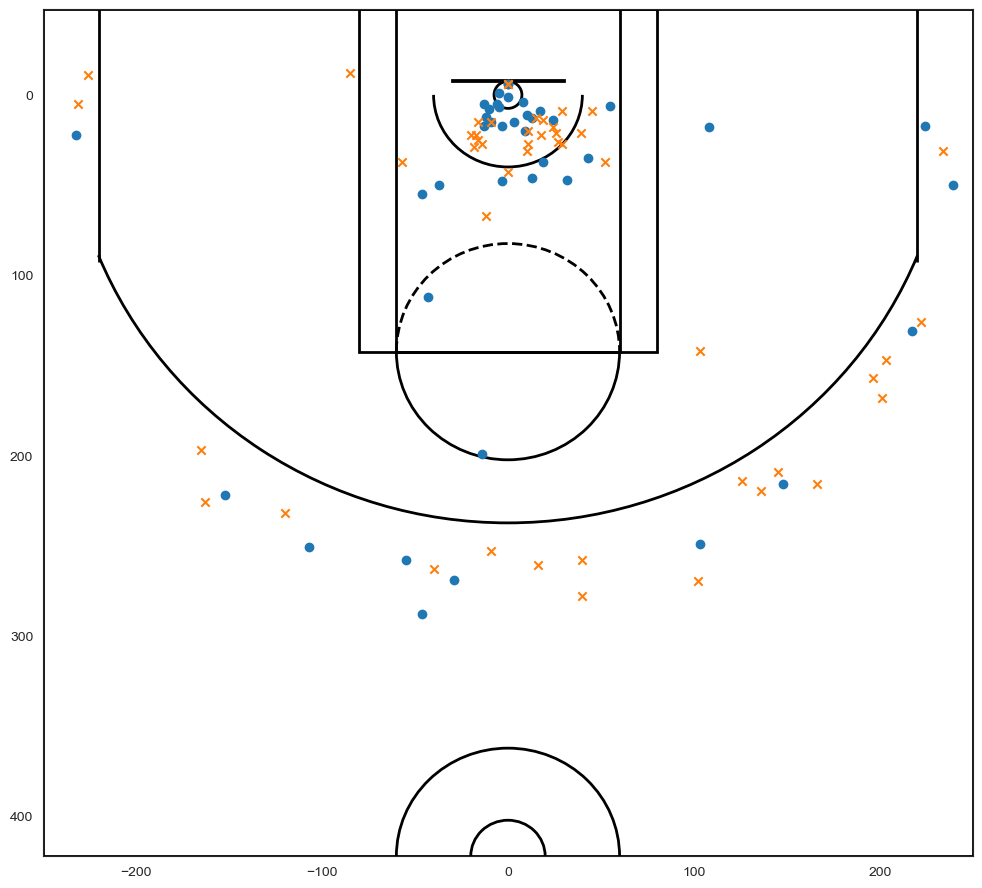

In [73]:
## Displays Shot Chart for first regular season game used for training model

shotsMade_Raptors_Game1 =[]
shotsMissed_Raptors_Game1 =[]

for i in range(len(df_FGA_Raptors_Game1)):
    if df_FGA_Raptors_Game1.SHOT_MADE_FLAG.iloc[i] == 1:
        shotsMade_Raptors_Game1.append(df_FGA_Raptors_Game1.iloc[i])
    else:
        shotsMissed_Raptors_Game1.append(df_FGA_Raptors_Game1.iloc[i])
        
df_shotsMade_Raptors_Game1 = pd.DataFrame(df_shotsMade_Raptors_Game1)
df_shotsMissed_Raptors_Game1 = pd.DataFrame(shotsMissed_Raptors_Game1)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_shotsMade_Raptors_Game1.LOC_X, df_shotsMade_Raptors_Game1.LOC_Y)
plt.scatter(df_shotsMissed_Raptors_Game1.LOC_X,df_shotsMissed_Raptors_Game1.LOC_Y, marker = "x")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.show()

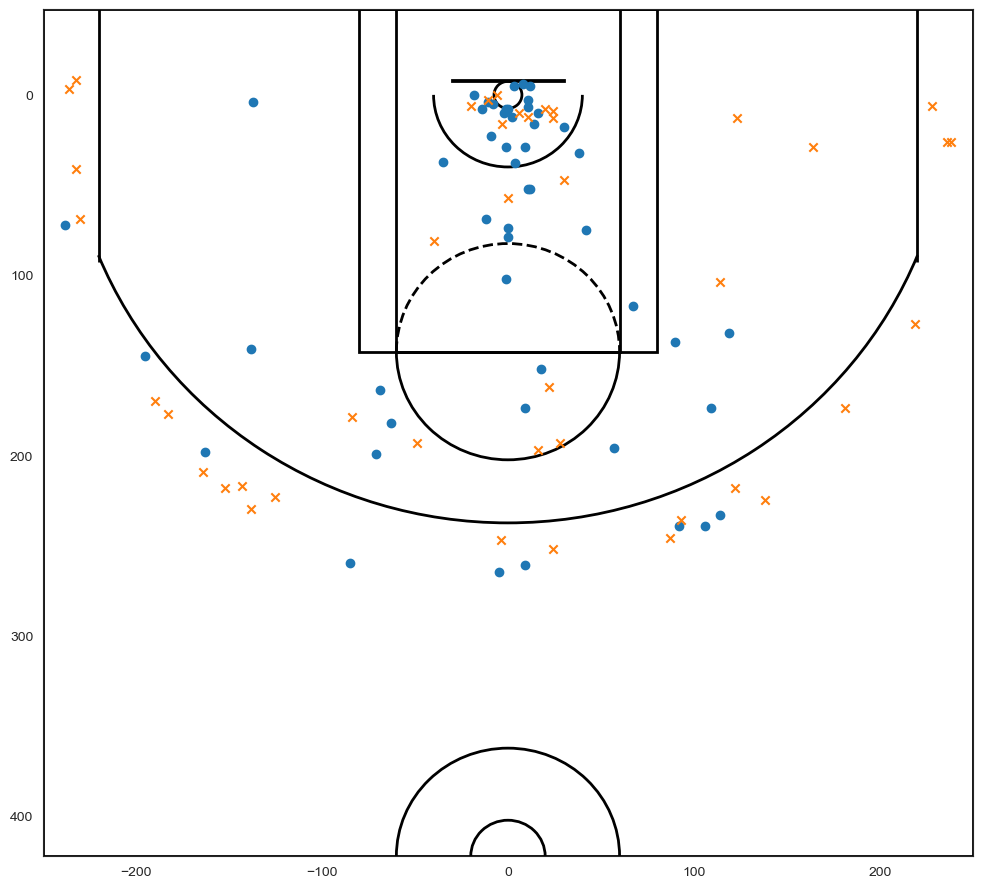

In [67]:
## Displays Shot Chart for second regular season game used for training model
shotsMade_Raptors_Game2 =[]
shotsMissed_Raptors_Game2 =[]

for i in range(len(df_FGA_Raptors_Game2)):
    if df_FGA_Raptors_Game2.SHOT_MADE_FLAG.iloc[i] == 1:
        shotsMade_Raptors_Game2.append(df_FGA_Raptors_Game2.iloc[i])
    else:
        shotsMissed_Raptors_Game2.append(df_FGA_Raptors_Game2.iloc[i])
        
df_shotsMade_Raptors_Game2 = pd.DataFrame(shotsMade_Raptors_Game2)
df_shotsMissed_Raptors_Game2 = pd.DataFrame(shotsMissed_Raptors_Game2)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_shotsMade_Raptors_Game2.LOC_X, df_shotsMade_Raptors_Game2.LOC_Y)
plt.scatter(df_shotsMissed_Raptors_Game2.LOC_X,df_shotsMissed_Raptors_Game2.LOC_Y, marker = "x")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.show()

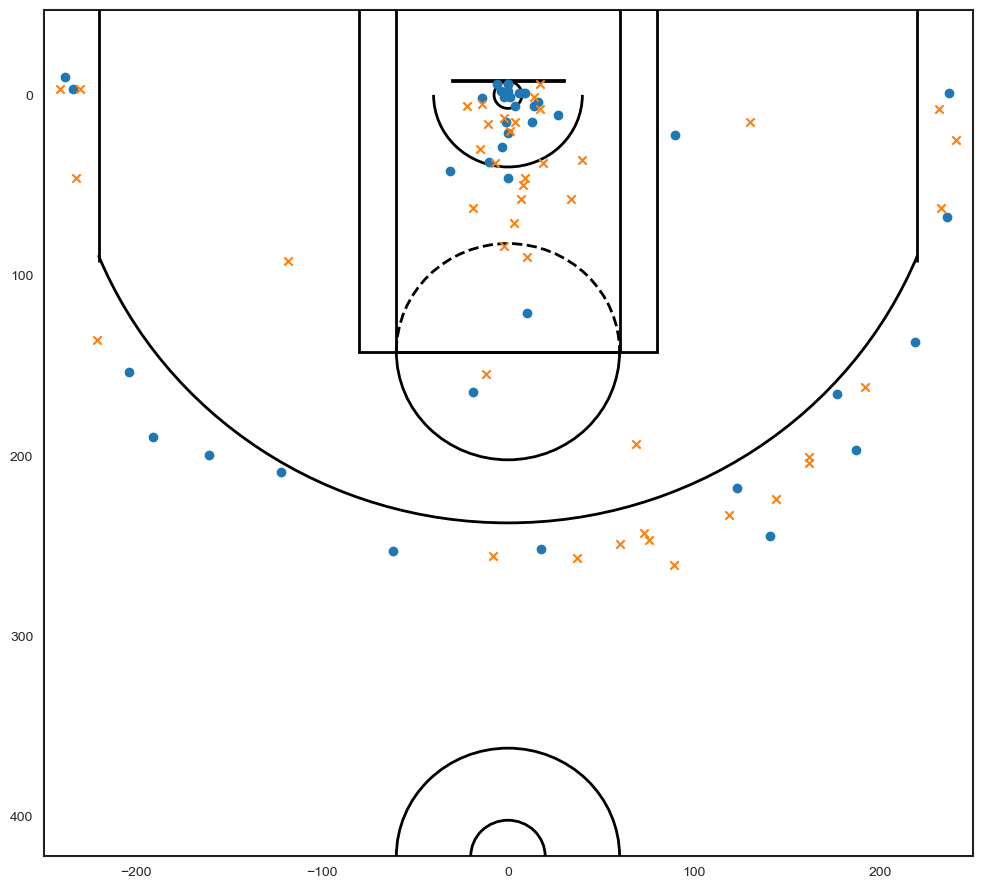

In [68]:
## Displays Shot Chart for third regular season game used for training model
shotsMade_Raptors_Game3 =[]
shotsMissed_Raptors_Game3 =[]

for i in range(len(df_FGA_Raptors_Game3)):
    if df_FGA_Raptors_Game3.SHOT_MADE_FLAG.iloc[i] == 1:
        shotsMade_Raptors_Game3.append(df_FGA_Raptors_Game3.iloc[i])
    else:
        shotsMissed_Raptors_Game3.append(df_FGA_Raptors_Game3.iloc[i])
        
df_shotsMade_Raptors_Game3 = pd.DataFrame(shotsMade_Raptors_Game3)
df_shotsMissed_Raptors_Game3 = pd.DataFrame(shotsMissed_Raptors_Game3)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_shotsMade_Raptors_Game3.LOC_X, df_shotsMade_Raptors_Game3.LOC_Y)
plt.scatter(df_shotsMissed_Raptors_Game3.LOC_X,df_shotsMissed_Raptors_Game3.LOC_Y, marker = "x")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.show()

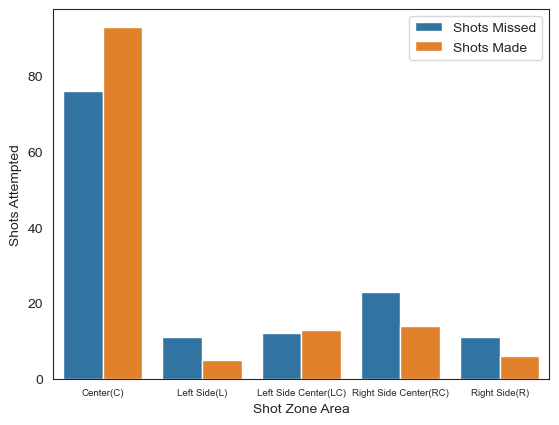

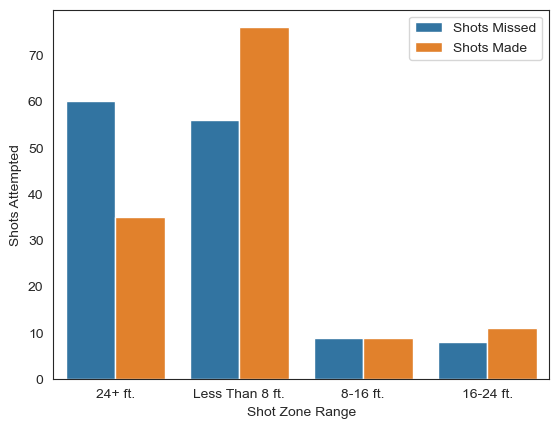

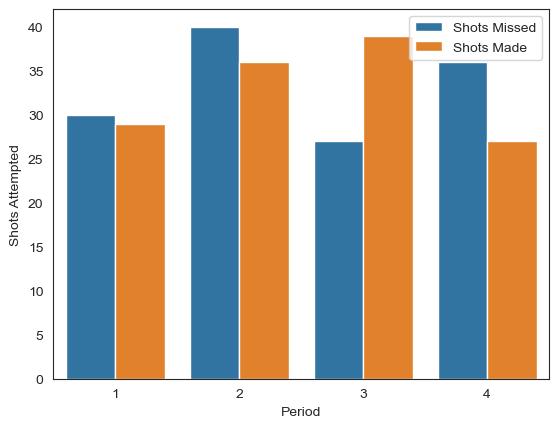

In [198]:
## Displays data from training set of all 3 features. 

ax = sns.countplot(x = 'SHOT_ZONE_AREA', data = df_FGA_Raptors_RS, hue = 'SHOT_MADE_FLAG')
ax.set(xlabel = 'Shot Zone Area',ylabel = 'Shots Attempted')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
ax.legend(('Shots Missed','Shots Made'))
plt.show()

ax2 =sns.countplot(x = 'SHOT_ZONE_RANGE', data = df_FGA_Raptors_RS, hue = 'SHOT_MADE_FLAG')
ax2.set(xlabel = 'Shot Zone Range', ylabel = 'Shots Attempted')
ax2.legend(('Shots Missed','Shots Made'))
plt.show()

ax3 =sns.countplot(x = 'PERIOD', data = df_FGA_Raptors_RS, hue = 'SHOT_MADE_FLAG')
ax3.set(xlabel = 'Period', ylabel = 'Shots Attempted')
ax3.legend(('Shots Missed','Shots Made'))
plt.show()

## Create model, Process Data and Evaluate predictions

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Creates model for predicting Raptors xP

features = ['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD']

newFGA_Raptors_RS = df_FGA_Raptors_RS.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testFGA_Raptors_RS = pd.get_dummies(newFGA_Raptors_RS, columns = features)


X = testFGA_Raptors_RS.drop('SHOT_MADE_FLAG', axis =1).values
y = testFGA_Raptors_RS['SHOT_MADE_FLAG']
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.70, test_size = 0.3)

modelRaptors = LogisticRegression(random_state = 10)
modelRaptors.fit(X_train, y_train)


C:\Users\DJZoonie\AppData\Local\Temp\ipykernel_10704\3357766256.py:11: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  testFGA_Raptors_RS = pd.get_dummies(newFGA_Raptors_RS, columns = features)


LogisticRegression(random_state=10)

In [190]:
## Organizes data of shots attemted by the Raptors vs 76ers in a way that is usable for model and determines xG

RaptorsFGAvsPhilly =[]
for id in playerID_Raptors:
    
    playerFGA = shotchartdetail.ShotChartDetail(season_nullable = '2018-19',
                                            team_id = '1610612761',
                                            player_id = id,
                                            season_type_all_star = 'Playoffs',
                                            game_id_nullable ='0041800217',
                                            context_measure_simple ="FGA").get_data_frames()[0]
    RaptorsFGAvsPhilly.append(playerFGA)
df_RaptorsFGAvsPhilly = pd.concat(RaptorsFGAvsPhilly, ignore_index =True)

newRaptorsFGAvsPhilly = df_RaptorsFGAvsPhilly.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testRaptorsFGAvsPhilly = pd.get_dummies(newRaptorsFGAvsPhilly, columns = features)

XRaptorsvsPhilly = testRaptorsFGAvsPhilly.drop('SHOT_MADE_FLAG', axis =1).values

y_testRaptorsvsPhilly = testRaptorsFGAvsPhilly.loc[:,"SHOT_MADE_FLAG"].to_numpy()
y_predRaptorsvsPhilly = modelRaptors.predict(XRaptorsvsPhilly)

y_testRaptorsvsPhilly = y_testRaptorsvsPhilly.astype(int)



C:\Users\DJZoonie\AppData\Local\Temp\ipykernel_10704\162655634.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  testRaptorsFGAvsPhilly = pd.get_dummies(newRaptorsFGAvsPhilly, columns = features)


In [191]:
## Transforms xG predictions to xP for Raptors vs 76ers
xPRaptorsvsPhilly = 0

for i in range(len(y_predRaptorsvsPhilly)):
    
    if y_predRaptorsvsPhilly[i] == 1:
        if newRaptorsFGAvsPhilly['SHOT_ZONE_RANGE'][i] == '24+ ft.':
            xPRaptorsvsPhilly = xPRaptorsvsPhilly + 3.0
        else:
            xPRaptorsvsPhilly = xPRaptorsvsPhilly + 2.0

print(xPRaptorsvsPhilly)

93.0


              precision    recall  f1-score   support

           0       0.72      0.56      0.63        55
           1       0.48      0.65      0.55        34

    accuracy                           0.60        89
   macro avg       0.60      0.61      0.59        89
weighted avg       0.63      0.60      0.60        89



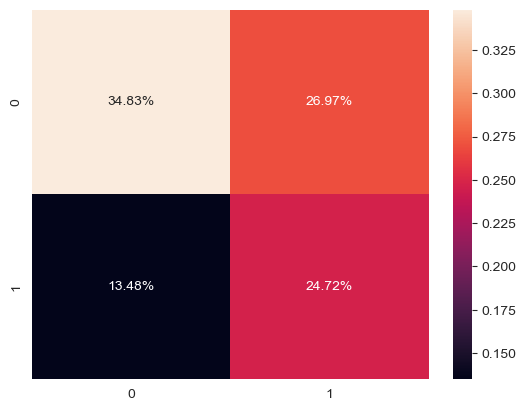

In [188]:
## Accuracy, f1-Score and confusion matrix
from sklearn.metrics import confusion_matrix

print(metrics.classification_report(y_testRaptorsvsPhilly,y_predRaptorsvsPhilly))
confusion_matrix = confusion_matrix(y_testRaptorsvsPhilly,y_predRaptorsvsPhilly)
heatmap = sns.heatmap(data = confusion_matrix/np.sum(confusion_matrix), annot = True,fmt='.2%')
plt.show()

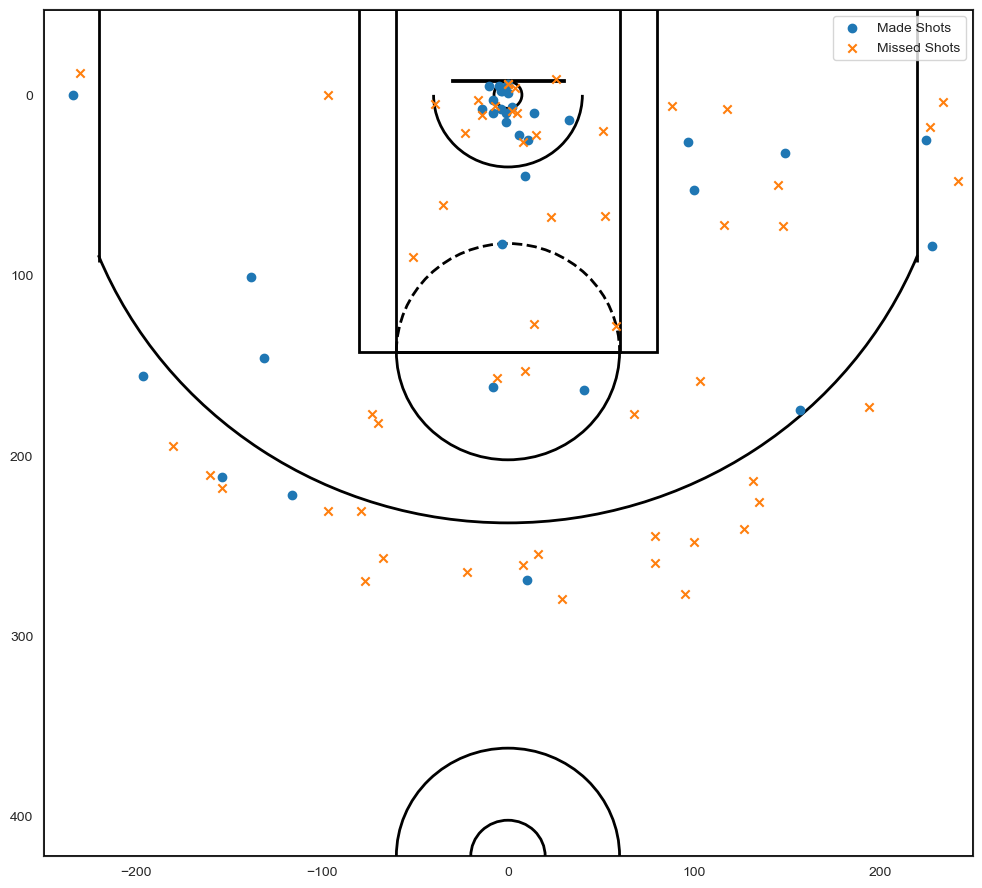

In [194]:
## Makes an Actual Shot Chart and Predicted Shot Chart for Raptors vs 76ers during Game 7

shotsMadeRaptorsvsPhilly =[]
shotsMissedRaptorsvsPhilly =[]

for i in range(len(df_RaptorsFGAvsPhilly)):
    if df_RaptorsFGAvsPhilly.SHOT_MADE_FLAG.iloc[i] == 1:
        shotsMadeRaptorsvsPhilly.append(df_RaptorsFGAvsPhilly.iloc[i])
    else:
        shotsMissedRaptorsvsPhilly.append(df_RaptorsFGAvsPhilly.iloc[i])
        
df_shotsMadeRaptorsvsPhilly = pd.DataFrame(shotsMadeRaptorsvsPhilly)
df_shotsMissedRaptorsvsPhilly = pd.DataFrame(shotsMissedRaptorsvsPhilly)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_shotsMadeRaptorsvsPhilly.LOC_X, df_shotsMadeRaptorsvsPhilly.LOC_Y, label="Made Shots")
plt.scatter(df_shotsMissedRaptorsvsPhilly.LOC_X,df_shotsMissedRaptorsvsPhilly.LOC_Y, marker = "x", label="Missed Shots")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.legend(loc="upper right")
plt.show()

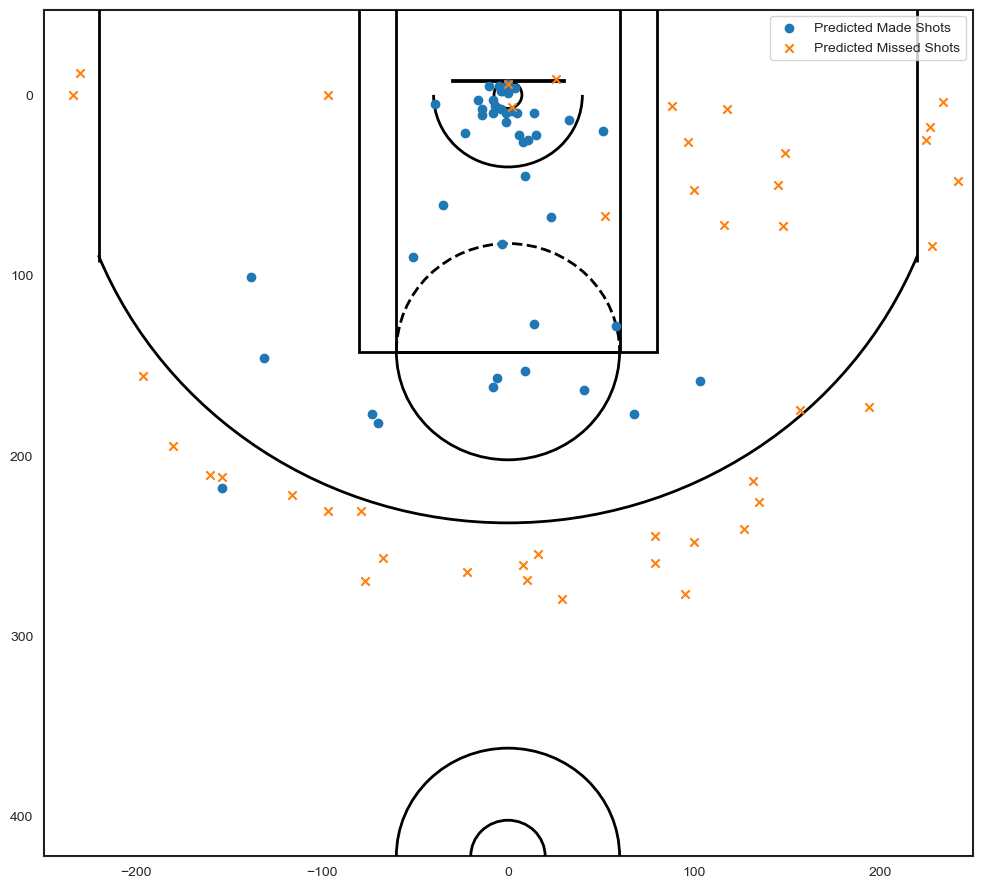

In [192]:
df_RaptorsFGAvsPhilly["PRED_SHOT_MADE_FLAG"] = y_predRaptorsvsPhilly

predShotsMadeRaptorsvsPhilly =[]
predShotsMissedRaptorsvsPhilly =[]

for i in range(len(df_RaptorsFGAvsPhilly)):
    if df_RaptorsFGAvsPhilly.PRED_SHOT_MADE_FLAG.iloc[i] == 1:
        predShotsMadeRaptorsvsPhilly.append(df_RaptorsFGAvsPhilly.iloc[i])
    else:
        predShotsMissedRaptorsvsPhilly.append(df_RaptorsFGAvsPhilly.iloc[i])
        
df_predShotsMadeRaptorsvsPhilly = pd.DataFrame(predShotsMadeRaptorsvsPhilly)
df_predShotsMissedRaptorsvsPhilly = pd.DataFrame(predShotsMissedRaptorsvsPhilly)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_predShotsMadeRaptorsvsPhilly.LOC_X, df_predShotsMadeRaptorsvsPhilly.LOC_Y,label="Predicted Made Shots")
plt.scatter(df_predShotsMissedRaptorsvsPhilly.LOC_X,df_predShotsMissedRaptorsvsPhilly.LOC_Y, marker = "x",label="Predicted Missed Shots")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.legend(loc="upper right")
plt.show()

In [123]:
## Organizes data of shots attemted by the Raptors vs Warriors in a way that is usable for model and determines xG

RaptorsFGAvsWarriors =[]
for id in playerID_Raptors:
    
    playerFGA = shotchartdetail.ShotChartDetail(season_nullable = '2018-19',
                                            team_id = '1610612761',
                                            player_id = id,
                                            season_type_all_star = 'Playoffs',
                                            game_id_nullable ='0041800406',
                                            context_measure_simple ="FGA").get_data_frames()[0]
    RaptorsFGAvsWarriors.append(playerFGA)
df_RaptorsFGAvsWarriors = pd.concat(RaptorsFGAvsWarriors, ignore_index =True)

newRaptorsFGAvsWarriors = df_RaptorsFGAvsWarriors.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testRaptorsFGAvsWarriors = pd.get_dummies(newRaptorsFGAvsWarriors, columns = features)

XRaptorsFGAvsWarriors = testRaptorsFGAvsWarriors.drop('SHOT_MADE_FLAG', axis =1).values

y_predRaptorsFGAvsWarriors = modelRaptors.predict(XRaptorsFGAvsWarriors)

C:\Users\DJZoonie\AppData\Local\Temp\ipykernel_10704\2927988436.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  testRaptorsFGAvsWarriors = pd.get_dummies(newRaptorsFGAvsWarriors, columns = features)


In [124]:
## Determines xP for Raptors vs Warriors

xPRaptorsvsWarriors = 0

for i in range(len(y_predRaptorsFGAvsWarriors)):
    
    if y_predRaptorsFGAvsWarriors[i] == 1:
        if newRaptorsFGAvsWarriors['SHOT_ZONE_RANGE'][i] == '24+ ft.':
            xPRaptorsvsWarriors = xPRaptorsvsWarriors + 3.0
        else:
            xPRaptorsvsWarriors = xPRaptorsvsWarriors + 2.0

print(xPRaptorsvsWarriors)

94.0


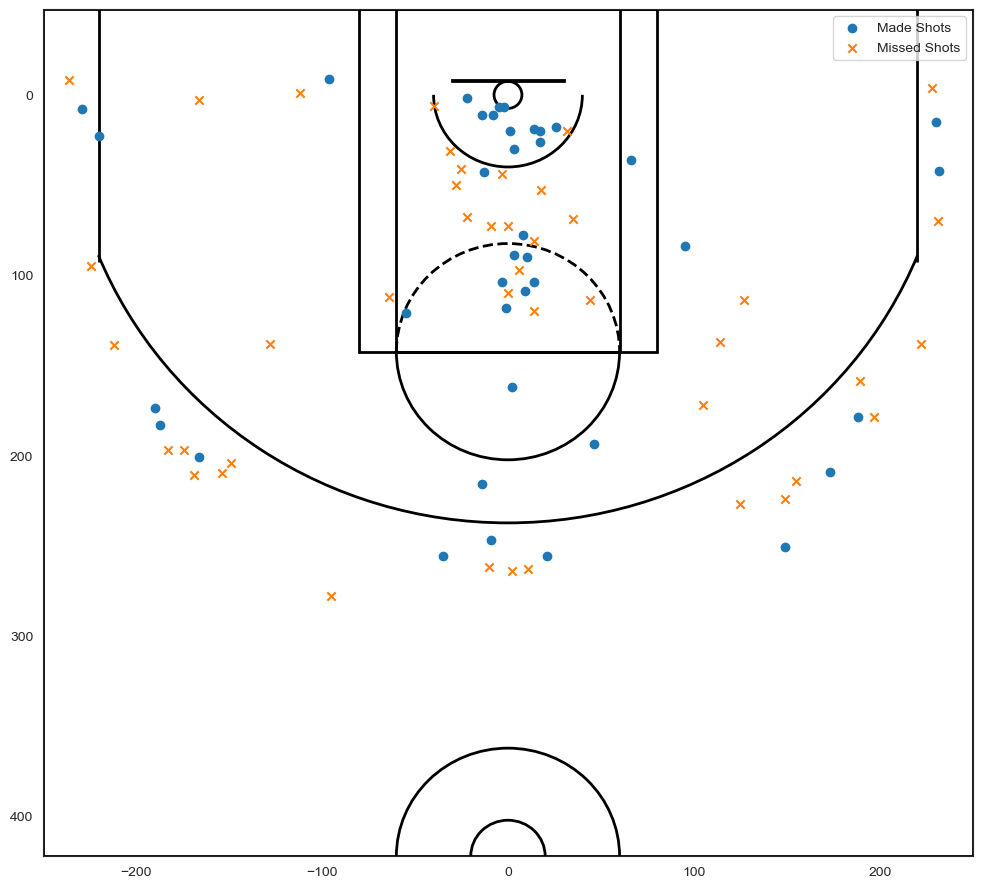

In [199]:
## Creates Actual Shot Chart and Predicted Shot Chart for Raptors vs Warriors during Game 6
df_RaptorsFGAvsWarriors["PRED_SHOT_MADE_FLAG"] = y_predRaptorsFGAvsWarriors

shotsMadeRaptorsvsWarriors =[]
shotsMissedRaptorsvsWarriors =[]

for i in range(len(df_RaptorsFGAvsWarriors)):
    if df_RaptorsFGAvsWarriors.SHOT_MADE_FLAG.iloc[i] == 1:
        shotsMadeRaptorsvsWarriors.append(df_RaptorsFGAvsWarriors.iloc[i])
    else:
        shotsMissedRaptorsvsWarriors.append(df_RaptorsFGAvsWarriors.iloc[i])
        
df_shotsMadeRaptorsvsWarriors = pd.DataFrame(shotsMadeRaptorsvsWarriors)
df_shotsMissedRaptorsvsWarriors = pd.DataFrame(shotsMissedRaptorsvsWarriors)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_shotsMadeRaptorsvsWarriors.LOC_X, df_shotsMadeRaptorsvsWarriors.LOC_Y, label="Made Shots")
plt.scatter(df_shotsMissedRaptorsvsWarriors.LOC_X,df_shotsMissedRaptorsvsWarriors.LOC_Y, marker = "x", label="Missed Shots")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.legend(loc="upper right")
plt.show()

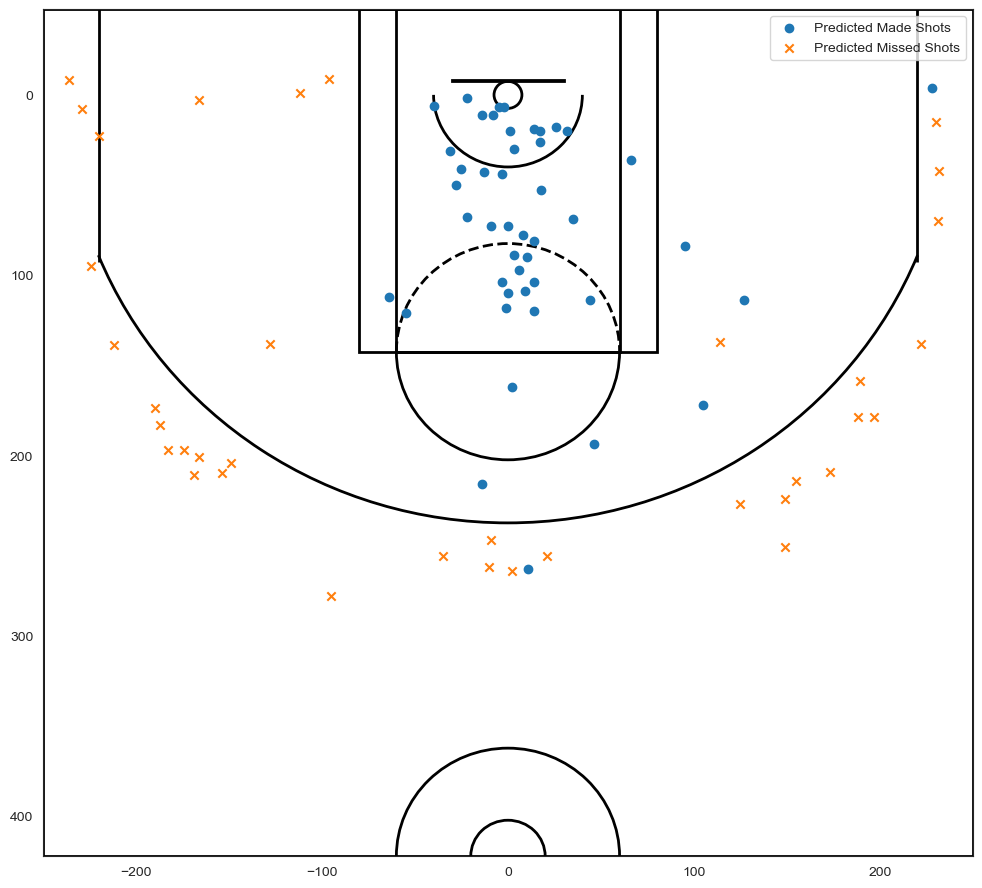

In [200]:
## Creates Predicted Shot Chart for Raptors vs Warriors during Game 6
predShotsMadeRaptorsvsWarriors =[]
predShotsMissedRaptorsvsWarriors =[]

for i in range(len(df_RaptorsFGAvsWarriors)):
    if df_RaptorsFGAvsWarriors.PRED_SHOT_MADE_FLAG.iloc[i] == 1:
        predShotsMadeRaptorsvsWarriors.append(df_RaptorsFGAvsWarriors.iloc[i])
    else:
        predShotsMissedRaptorsvsWarriors.append(df_RaptorsFGAvsWarriors.iloc[i])
        
df_predShotsMadeRaptorsvsWarriors = pd.DataFrame(predShotsMadeRaptorsvsWarriors)
df_predShotsMissedRaptorsvsWarriors = pd.DataFrame(predShotsMissedRaptorsvsWarriors)


sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(df_predShotsMadeRaptorsvsWarriors.LOC_X, df_predShotsMadeRaptorsvsWarriors.LOC_Y, label="Predicted Made Shots")
plt.scatter(df_predShotsMissedRaptorsvsWarriors.LOC_X,df_predShotsMissedRaptorsvsWarriors.LOC_Y, marker = "x", label="Predicted Missed Shots")
plt.xlim(-250,250)
plt.ylim(422.5,-47.5)
plt.legend(loc="upper right")
plt.show()

In [133]:
# Creates model for predicting 76ers xP
newFGA_76ers_RS = df_FGA_76ers_RS.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testFGA_76ers_RS = pd.get_dummies(newFGA_76ers_RS, columns = features)


X2 = testFGA_76ers_RS.drop('SHOT_MADE_FLAG', axis =1).values
y2 = testFGA_76ers_RS['SHOT_MADE_FLAG']
y2 = y2.astype(int)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, train_size = 0.70, test_size = 0.3)

model76ers = LogisticRegression(random_state = 10)
model76ers.fit(X_train2, y_train2)

C:\Users\DJZoonie\AppData\Local\Temp\ipykernel_10704\1188324528.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  testFGA_76ers_RS = pd.get_dummies(newFGA_76ers_RS, columns = features)


LogisticRegression(random_state=10)

In [136]:
## Organizes data of shots attemted by the 76ers vs Raptors in a way that is usable for model and determines xG
PhillyFGAvsRaptors =[]

for id in playerID_76ers:
    
    playerFGA = shotchartdetail.ShotChartDetail(season_nullable = '2018-19',
                                            team_id = teamID_76ers,
                                            player_id = id,
                                            season_type_all_star = 'Playoffs',
                                            game_id_nullable ='0041800217',
                                            context_measure_simple ="FGA").get_data_frames()[0]
    PhillyFGAvsRaptors.append(playerFGA)
df_PhillyFGAvsRaptors = pd.concat(PhillyFGAvsRaptors, ignore_index =True)

newPhillyFGAvsRaptors = df_PhillyFGAvsRaptors.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testPhillyFGAvsRaptors = pd.get_dummies(newPhillyFGAvsRaptors, columns = features)

XPhillyvsRaptors = testPhillyFGAvsRaptors.drop('SHOT_MADE_FLAG', axis =1).values


y_predPhillyvsRaptors = model76ers.predict(XPhillyvsRaptors)


In [154]:
## Transforms xG predictions to xP 
xPPhillyvsRaptors = 0

for i in range(len(y_predPhillyvsRaptors)):
    
    if y_predPhillyvsRaptors[i] == 1:
        if newPhillyFGAvsRaptors['SHOT_ZONE_RANGE'][i] == '24+ ft.':
            xPPhillyvsRaptors = xPPhillyvsRaptors + 3.0
        else:
            xPPhillyvsRaptors = xPPhillyvsRaptors + 2.0

print(xPPhillyvsRaptors)

75.0


In [139]:
# Creates model for predicting Warriors xP
newFGA_Warriors_RS = df_FGA_Warriors_RS.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testFGA_Warriors_RS = pd.get_dummies(newFGA_Warriors_RS, columns = features)


X3 = testFGA_Warriors_RS.drop('SHOT_MADE_FLAG', axis =1).values
y3 = testFGA_Warriors_RS['SHOT_MADE_FLAG']
y3 = y3.astype(int)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3, train_size = 0.70, test_size = 0.3)

modelWarriors = LogisticRegression(random_state = 10)
modelWarriors.fit(X_train3, y_train3)

C:\Users\DJZoonie\AppData\Local\Temp\ipykernel_10704\4170742798.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  testFGA_Warriors_RS = pd.get_dummies(newFGA_Warriors_RS, columns = features)


LogisticRegression(random_state=10)

In [153]:
## Organizes data of shots attemted by the Warriors vs Raptors in a way that is usable for model and determines xG
WarriorsFGAvsRaptors =[]

for id in playerID_Warriors:
    
    playerFGA = shotchartdetail.ShotChartDetail(season_nullable = '2018-19',
                                            team_id = teamID_Warriors,
                                            player_id = id,
                                            season_type_all_star = 'Playoffs',
                                            game_id_nullable ='0041800406',
                                            context_measure_simple ="FGA").get_data_frames()[0]
    WarriorsFGAvsRaptors.append(playerFGA)
df_WarriorsFGAvsRaptors = pd.concat(WarriorsFGAvsRaptors, ignore_index =True)

newWarriorsFGAvsRaptors = df_WarriorsFGAvsRaptors.filter(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PERIOD', 'SHOT_MADE_FLAG'], axis =1)
testWarriorsFGAvsRaptors = pd.get_dummies(newWarriorsFGAvsRaptors, columns = features)

XWarriorsvsRaptors = testWarriorsFGAvsRaptors.drop(['SHOT_MADE_FLAG', 'SHOT_ZONE_AREA_Back Court(BC)', 'SHOT_ZONE_RANGE_Back Court Shot'], axis =1).values
## Note: I took the liberty of removing the back court shot from the set of features because it is not one of the features
##       my model takes into account and it happened to be a missed shot. If I wanted to implement this model properly,
##       I could add those ranges but they are rare enough to exclude in this scenario.

y_predWarriorsvsRaptors = modelWarriors.predict(XWarriorsvsRaptors)

In [152]:
## Transforms xG predictions to xP 
xPWarriorsvsRaptors = 0

for i in range(len(y_predWarriorsvsRaptors)):
    
    if y_predWarriorsvsRaptors[i] == 1:
        if newWarriorsFGAvsRaptors['SHOT_ZONE_RANGE'][i] == '24+ ft.':
            xPWarriorsvsRaptors = xPWarriorsvsRaptors + 3.0
        else:
            xPWarriorsvsRaptors = xPWarriorsvsRaptors + 2.0

print(xPWarriorsvsRaptors)


102.0


## Results
Note that my model predicts the xP for shots attempted but does not include free throws made so I will take them into account here.

### Final Predicted Scores
#### Game 7: Raptors vs 76ers
119-100
#### Game6: Raptors vs Warriors
117 - 123

### Actual Final Scores
#### Game 7: Raptors vs 76ers
92-90
#### Game6: Raptors vs Warriors
114-110

### In conclusion, the Raptors didn't play above expectations for either games and still ended up winning against both teams. It's relevant to note that the Raptors were predicted to lose vs the Warriors in game 6 but the Warriors seemed to have underperformed compared to expectations.